# kNN Pixelwise Classifier

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import pickle
from time import time
import gc

In [3]:
# %load ../../../data_preprocessing/functions.py
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

# A function to plot a matrix
def plot_image(data, colorspace='binary'):
    fig = plt.figure(figsize=(10,10)) 
    ax = fig.add_subplot(111)
    ax.imshow(data, cmap=colorspace)
    
    
def normalize_array(array):
    array_min = array.min(axis=(0, 1), keepdims=True)
    array_max = array.max(axis=(0, 1), keepdims=True)
    normalized_array = (array - array_min)/(array_max - array_min)
    
    return normalized_array

def normalize_with_preset(array, max_value, min_value):
    normalized_array = (array - min_value)/(max_value - min_value)
    
    return normalized_array


def recreate_image(labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    image = np.zeros((w, h))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = labels[label_idx]
            label_idx += 1
    return image

def overlay_images(image1, image2, colorspace1='binary', colorspace2='magma', transparency=0.5):
    plt.imshow(image1, cmap=colorspace1, interpolation='nearest')
    plt.imshow(image2, cmap=colorspace2, alpha=transparency, interpolation='bilinear')
    plt.show()
    
def flatten_normalize_neighbors(training_set, global_max=233, global_min=69):
    flattened_neighbors = []
    neighbors = training_set['neighbors']

    for i in range(len(neighbors)):
        numpy_array = np.array(neighbors[i]).reshape(-1, 1)
        normalized_neighbors = normalize_with_preset(numpy_array, global_max, global_min)
        flattened_neighbors.append(normalized_neighbors)
    
    return np.array(flattened_neighbors).reshape((len(flattened_neighbors), -1))

def extract_values_from_training_data_locations(training_data, image_channel):
    data_values = []
    
    for row in training_data:
        data_values.append(np.array([(image_channel[row[0], row[1]]), row[2]]))
        
    data_values = np.array(data_values)
    
    return data_values

## Open up the files that contain the labels

In [4]:
training_set_values = np.load("../data/june10/training_data_values.npy")
training_set_labels = np.load("../data/june10/training_data_labels.npy")

In [5]:
pixels = training_set_values[:, 4].reshape(-1, 1)

## Extract data

In [6]:
# pixels = training_set_file[:, 0].reshape(-1, 1)
# labels = training_set_file[:, 1].flatten()

## Shuffle data and create splits

In [7]:
values_train, values_test, labels_train, labels_test = train_test_split(pixels, training_set_labels, test_size=0.10, random_state=0)

## Initialize the kNN algorithm

In [26]:
classifier = KNeighborsClassifier(n_neighbors=4, n_jobs=2)

In [27]:
classifier.fit(values_train, labels_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=2, n_neighbors=4, p=2,
           weights='uniform')

## Save the classifier for other things

In [29]:
from sklearn.externals import joblib

In [30]:
joblib.dump(classifier, './knn_trained_with_hsv_only_b.pkl') 

['./knn_trained_with_hsv_only_b.pkl']

## Load up the orthomosaic

In [31]:
image_data = np.load("../../../../data_preprocessing/data_preprocessing/numpy_data/indios_b/normalized_filtered_rgb.npy")[0:6000, 0:6000, :]
hsv_data = np.load("../../../../data_preprocessing/data_preprocessing/numpy_data/indios_b/normalized_filtered_hsv.npy")[0:6000, 0:6000, :]

In [32]:
image_data.shape

(6000, 6000, 3)

In [33]:
multidimensional_ortho = np.dstack((image_data, hsv_data))

In [39]:
multidimensional_ortho = hsv_data[:, :, 0]

In [12]:
# w, h, c = tuple(multidimensional_ortho.shape)

In [47]:
# w, h, c = tuple(hsv_data[:, :, 0].shape)
w, h = tuple(hsv_data[:, :, 0].shape)

In [38]:
gc.collect()

4729

In [41]:
# reshaped_ortho = multidimensional_ortho.reshape(w*h, -1, 6)
reshaped_ortho = multidimensional_ortho.reshape(-1, 1)

In [44]:
# reshaped_ortho.reshape(-1, 6)

In [48]:
predicted_image = np.zeros((w, h))

In [49]:
# labels = classifier.predict(reshaped_ortho.reshape(-1, 6))
labels = classifier.predict(reshaped_ortho)

In [50]:
t0 = time()
image = recreate_image(labels, w, h)
print("done in %0.3fs." % (time() - t0))

done in 12.237s.


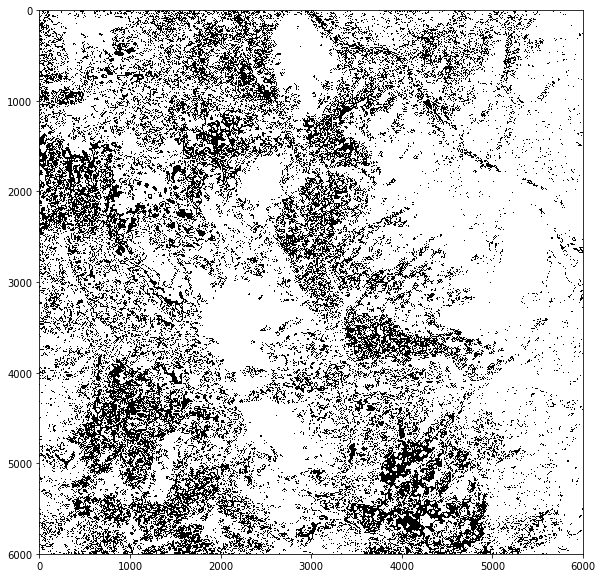

In [51]:
plot_image(image)

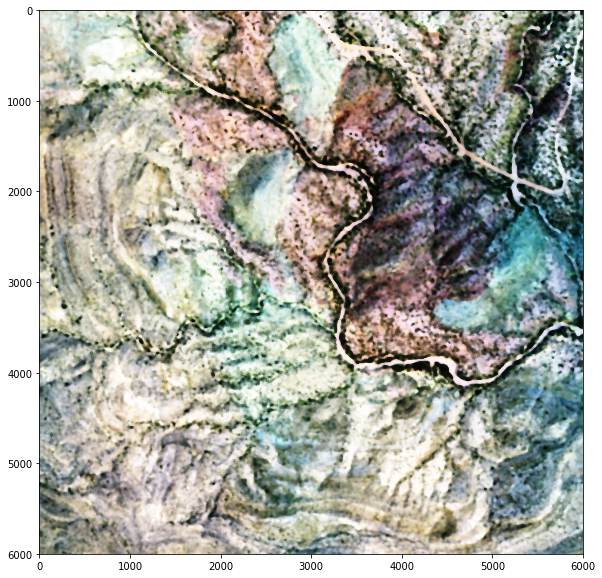

In [52]:
plot_image(image_data)

In [85]:
from skimage.filters.rank import median
from skimage.morphology import disk, binary_dilation, closing, binary_erosion, binary_opening

In [110]:
dil = binary_dilation(image, selem=disk(5))

In [105]:
ope = binary_opening(dil, selem=disk(4))

In [113]:
med = median(dil, disk(10))

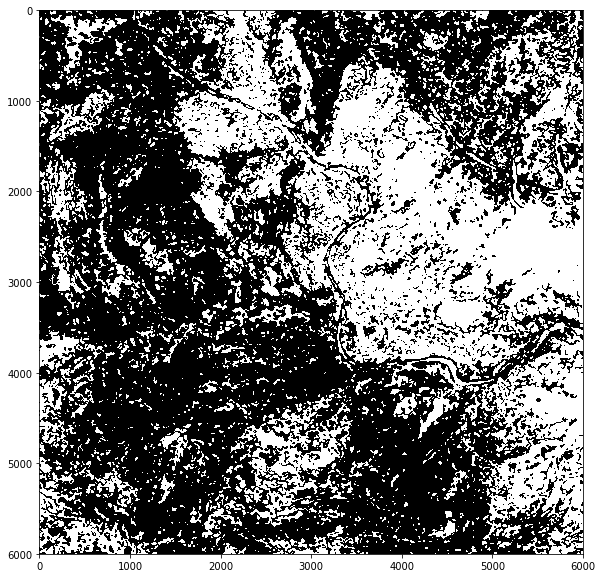

In [114]:
plot_image(med)

In [ ]:
# t0 = time()
# prediction_map = np.zeros((w, h))
# for i in range(20, w-20):
#     for j in range(20, h-20):
#         test = test_mosaic[i-20:i+20, j-20:j+20].reshape(1, -1)
# #         print(i, j)
#         prediction = classifier.predict(test)
#         prediction_map[i][j] = prediction[0]
# print("done in %0.3fs." % (time() - t0))

In [8]:
from sklearn.metrics import classification_report
from sklearn.externals import joblib
clf = joblib.load('./knn_trained_with_hsv_only_b.pkl')

predicted_test_labels = clf.predict(values_test)

target_names = ["Bluff Mesa Formation", "Lower Yucca"]
print(classification_report(labels_test, predicted_test_labels, target_names=target_names))

                      precision    recall  f1-score   support

Bluff Mesa Formation       0.69      0.75      0.72        61
         Lower Yucca       0.48      0.40      0.44        35

         avg / total       0.61      0.62      0.62        96

